##NBA shot log data- Best and worst shot defender analysis

Data obtained from kaggle website.  This notebook is an expansion of Edward Yun's analysis, which was posted on the kaggle site as well.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#Import shots DF and create defender DF, or a list of all the players who defended shots
shots = pd.read_csv("/Users/matthu24/.spyder2-py3/shot_logs .csv",encoding='ISO-8859-1')
defender_df = pd.concat([shots["CLOSEST_DEFENDER_PLAYER_ID"],shots["CLOSEST_DEFENDER"]],axis = 1, keys = ["Defender_ID","Player"])
defender_df = defender_df.drop_duplicates()
print(defender_df.head(5))


   Defender_ID             Player
0       101187     Anderson, Alan
1       202711  Bogdanovic, Bojan
3       203900      Brown, Markel
4       201152    Young, Thaddeus
5       101114    Williams, Deron


In [4]:
#Create shooter DF
shooter_df = pd.concat([shots["player_id"],shots["player_name"]],axis = 1, keys =  ["Shooter_ID","Shooter_name"])
shooter_df = shooter_df.drop_duplicates()


In [6]:
#Create field goals made(FGM), field goals attempted(FGA), and 
#field goal percentage (FG%) columns for the shooter_df
for index, row in shooter_df.iterrows():
    this_id = row['Shooter_ID']
    
    #Note:
    #1. Indexing strategy: DF.loc[row,column]
    #2. count() method can only count a series hence the need to specify a column name 
    
    #create FGM column: for each shooter, filter out shots DF to include only rows with the 
    #shooter, and also made shots.  Count up the rows to get FGM value for each shooter.  
    shooter_df.loc[ (shooter_df['Shooter_ID'] == this_id), 'FGM'] = shots[ (shots['SHOT_RESULT'] == 'made') 
            & (shots['player_id'] == this_id)]['player_name'].count()
    
    #create FGA column
    shooter_df.loc[(shooter_df["Shooter_ID"]==this_id),"FGA"] = shots[(shots["player_id"]==this_id)]["player_name"].count()
    
    shooter_df["FG%"] = shooter_df["FGM"]/shooter_df["FGA"]

best_FGPercent = shooter_df.sort_values(by = "FG%",ascending = False)
print(best_FGPercent.head(10))


        Shooter_ID    Shooter_name  FGM  FGA       FG%
109092      201599  deandre jordan  280  393  0.712468
36622         2199  tyson chandler  230  340  0.676471
8408        203497     rudy gobert  167  267  0.625468
37817       202962      greg smith   29   47  0.617021
34368       201949   james johnson  191  311  0.614148
10523       202334        ed davis  211  350  0.602857
30838       201582   alexis ajinca  126  211  0.597156
124686      203486   mason plumlee  236  403  0.585608
74776       203089     john henson  140  241  0.580913
95766         2365  chris andersen   79  136  0.580882


In [11]:
#Create defender field goal attempt (number of shots defender defended against), defender field 
#goal made (number of shots that went in against the defender), and DFG% (defender field goal %)
for index, row in defender_df.iterrows():
    this_id = row["Defender_ID"]
    defender_df.loc[(defender_df["Defender_ID"] == this_id),"DFGM"] = shots[(shots["SHOT_RESULT"]=="made")
            & (shots["CLOSEST_DEFENDER_PLAYER_ID"] ==this_id)]["player_name"].count()
    defender_df.loc[(defender_df["Defender_ID"]==this_id),"DFGA"] = shots[(shots["CLOSEST_DEFENDER_PLAYER_ID"]==this_id)]["player_name"].count()
    defender_df["DFG%"] = defender_df["DFGM"]/defender_df["DFGA"]  

#Create "offensive field goal percentage" (OFG%) column, which will be defined as 
#the average combined field goal percentage of all the shooters a particular defender has
#ever defended
    OFGM = 0
    OFGA = 0
    for shooter_index,shooter_row in shooter_df.iterrows():
        this_shooter_id = shooter_row["Shooter_ID"]
        #checking if the particular shooter was defended by the defender ever
        shots_against_player = shots[(shots["player_id"] == this_shooter_id) & (shots["CLOSEST_DEFENDER_PLAYER_ID"] == this_id)]["player_name"].count() 
        if shots_against_player>0:
            #every shooter being defended by the defender in question needs to add their shots made and attempted
            OFGM += shots[(shots["SHOT_RESULT"]=="made") & (shots["player_id"]==this_shooter_id)]["player_name"].count()
            OFGA += shots[shots["player_id"]==this_shooter_id]["player_name"].count()
    OFG = OFGM/OFGA
    defender_df.loc[(defender_df["Defender_ID"]==this_id),"OFG%"] = OFG
        
#diff column is the difference between the average field goal percentage of all the shooters
#a defender has defended against, and the field goal percentage of only the shots the 
#the defender defended against: the higher the difference, the better the defender
defender_df["diff"] = defender_df["OFG%"]-defender_df["DFG%"]

#Best shot defenders 

In [16]:
defender_diff= defender_df.sort_values(by = "diff",ascending = False)
#filter out DF to defenders who have defended at least 300 shots
defender_diff_300 = defender_diff[defender_diff["DFGA"]>300]
print(defender_diff_300.head(10))

      Defender_ID            Player  DFGM  DFGA      DFG%      OFG%      diff
908          2754       Allen, Tony   113   318  0.355346  0.446681  0.091335
1331       203460   Roberson, Andre   120   320  0.375000  0.451885  0.076885
978        101106     Bogut, Andrew   168   433  0.387991  0.460198  0.072207
440        203497      Gobert, Rudy   192   489  0.392638  0.458280  0.065642
186        203114  Middleton, Khris   165   421  0.391924  0.447774  0.055850
190        201564        Mayo, O.J.   140   360  0.388889  0.443321  0.054432
135        201579      Hibbert, Roy   212   517  0.410058  0.463919  0.053861
272        203110   Green, Draymond   301   751  0.400799  0.452332  0.051533
261        201939    Curry, Stephen   209   527  0.396584  0.446906  0.050322
147        202709      Joseph, Cory   158   396  0.398990  0.448169  0.049180


The best shot defenders seem to be Tony Allen, Andre Roberson, and Andrew Bogut.  

#Worst shot defenders

In [18]:
defender_diff = defender_df.sort_values(by = "diff", ascending = True)
#filter out DF to defenders who have defended at least 100 shots
defender_diff_100 = defender_diff[defender_diff["DFGA"]>100]
print(defender_diff_100.head(10))

      Defender_ID             Player  DFGM  DFGA      DFG%      OFG%      diff
153        101181     Calderon, Jose   166   297  0.558923  0.447734 -0.111189
121        203516       Ennis, James    91   167  0.544910  0.444408 -0.100502
238        203561    Davies, Brandon    80   145  0.551724  0.456371 -0.095353
9448       203144      Shved, Alexey    61   116  0.525862  0.441178 -0.084685
392          2365    Andersen, Chris   143   265  0.539623  0.460305 -0.079318
132        203897       LaVine, Zach   155   297  0.521886  0.443534 -0.078352
1768       203461   Bennett, Anthony   133   250  0.532000  0.456700 -0.075300
3851         2592       Jones, James    55   107  0.514019  0.441967 -0.072051
228          2760  Varejao, Anderson   156   294  0.530612  0.458867 -0.071746
1925       203925        Harris, Joe    52   102  0.509804  0.439087 -0.070717


The above analysis does not take into account number of dribbles, time on shot clock, distance from hoop, or defender distance from shooter.

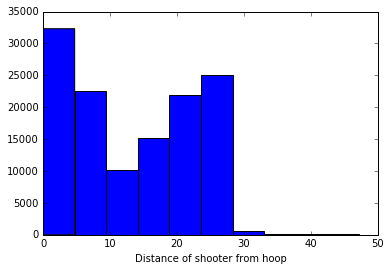

In [19]:
plt.hist(shots["SHOT_DIST"])
plt.xlabel("Distance of shooter from hoop")
plt.show()

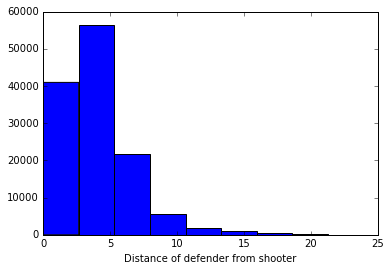

In [27]:
plt.hist(shots["CLOSE_DEF_DIST"],bins = 20)
plt.xlabel("Distance of defender from shooter")
plt.xlim(0,25)
plt.show()

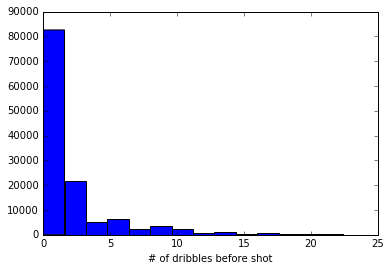

In [30]:
plt.hist(shots["DRIBBLES"],bins = 20)
plt.xlabel("# of dribbles before shot")
plt.xlim(0,25)
plt.show()

For each defender, add average dribbles column, average defender distance, and average shot distance.

In [34]:
for defender_index,defender_row in defender_df.iterrows():
    this_defender = defender_row["Defender_ID"]
    
    #average defender distance
    shots_defended_DF = shots[(shots["CLOSEST_DEFENDER_PLAYER_ID"] == this_defender)]
    #filter out shots DF into the rows that correspond to the particular defender
    Defender_Distance_sum = 0
    Shot_distance_sum = 0
    for index,row in shots_defended_DF.iterrows():
        #for each row, 
        Defender_Distance_sum += row["CLOSE_DEF_DIST"]
        Shot_distance_sum += row["SHOT_DIST"]
    Average_defender_distance = Defender_Distance_sum/len(shots_defended_DF)
    Average_shot_distance = Shot_distance_sum/len(shots_defended_DF)
    defender_df.loc[(defender_df["Defender_ID"]==this_defender),"Average Defender Distance"] = Average_defender_distance
    defender_df.loc[(defender_df["Defender_ID"]==this_defender),"Average Shot Distance"] = Average_shot_distance
print(defender_df.head(10))
    
    


    Defender_ID             Player  DFGM  DFGA      DFG%      OFG%      diff  \
0        101187     Anderson, Alan   174   383  0.454308  0.446833 -0.007475   
1        202711  Bogdanovic, Bojan   130   320  0.406250  0.450068  0.043818   
3        203900      Brown, Markel    23    50  0.460000  0.446356 -0.013644   
4        201152    Young, Thaddeus   256   532  0.481203  0.454338 -0.026865   
5        101114    Williams, Deron   150   331  0.453172  0.445280 -0.007892   
6        101127      Jack, Jarrett   236   532  0.443609  0.447795  0.004186   
7        203486     Plumlee, Mason   259   503  0.514911  0.461527 -0.053383   
8        202721     Morris, Darius    27    56  0.482143  0.443712 -0.038431   
9        201961   Ellington, Wayne   132   319  0.413793  0.442334  0.028540   
10       202391        Lin, Jeremy   224   483  0.463768  0.450417 -0.013351   

    Average Defender Distance  Average Shot Distance  
0                    4.536815              16.003394  
1        

Find distribution of average defender distances and average shot distances.

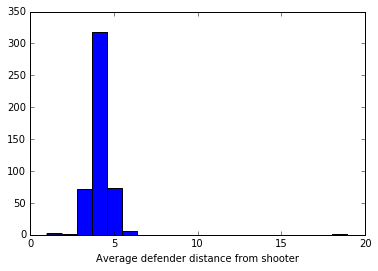

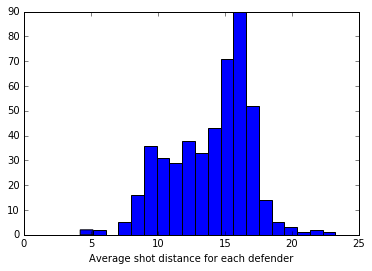

In [41]:
plt.hist(defender_df["Average Defender Distance"],bins = 20)
plt.xlabel("Average defender distance from shooter")
plt.show()
plt.hist(defender_df["Average Shot Distance"],bins = 20)
plt.xlabel("Average shot distance for each defender")
plt.show()

In [43]:
print(defender_df.head(10))

    Defender_ID             Player  DFGM  DFGA      DFG%      OFG%      diff  \
0        101187     Anderson, Alan   174   383  0.454308  0.446833 -0.007475   
1        202711  Bogdanovic, Bojan   130   320  0.406250  0.450068  0.043818   
3        203900      Brown, Markel    23    50  0.460000  0.446356 -0.013644   
4        201152    Young, Thaddeus   256   532  0.481203  0.454338 -0.026865   
5        101114    Williams, Deron   150   331  0.453172  0.445280 -0.007892   
6        101127      Jack, Jarrett   236   532  0.443609  0.447795  0.004186   
7        203486     Plumlee, Mason   259   503  0.514911  0.461527 -0.053383   
8        202721     Morris, Darius    27    56  0.482143  0.443712 -0.038431   
9        201961   Ellington, Wayne   132   319  0.413793  0.442334  0.028540   
10       202391        Lin, Jeremy   224   483  0.463768  0.450417 -0.013351   

    Average Defender Distance  Average Shot Distance  
0                    4.536815              16.003394  
1        

Rank best long distance shooter defenders(>16 ft).  Rank best short distance shooter  defenders (< 10 ft).  Are defenders that on average get closer to their shooter better shot defenders?  Plot diff vs. average defender distance for each player

In [50]:
#best short range shot defenders
short_defenders = defender_df[(defender_df["Average Shot Distance"]<10)&(defender_df["DFGA"]>100)]
print(short_defenders.sort_values(by = "diff",ascending = False).head(10))

      Defender_ID             Player  DFGM  DFGA      DFG%      OFG%  \
978        101106      Bogut, Andrew   168   433  0.387991  0.460198   
440        203497       Gobert, Rudy   192   489  0.392638  0.458280   
935          2223  Dalembert, Samuel    94   231  0.406926  0.462430   
135        201579       Hibbert, Roy   212   517  0.410058  0.463919   
1198       203120   Hamilton, Justin    43   106  0.405660  0.458562   
5101       202687   Biyombo, Bismack   102   244  0.418033  0.462850   
1183       203544        Antic, Pero    87   205  0.424390  0.463998   
138        101133       Mahinmi, Ian   107   248  0.431452  0.462380   
8679       202355  Whiteside, Hassan   100   229  0.436681  0.462473   
899        201188        Gasol, Marc   274   629  0.435612  0.458022   

          diff  Average Defender Distance  Average Shot Distance  
978   0.072207                   3.724942               9.597921  
440   0.065642                   3.677505               8.854806  
935   

In [52]:
#Best long range shot defenders
long_defenders = defender_df[(defender_df["Average Shot Distance"]>16)&(defender_df["DFGA"]>100)]
print(long_defenders.sort_values(by = "diff",ascending = False).head(10))

       Defender_ID              Player  DFGM  DFGA      DFG%      OFG%  \
7308          1889       Miller, Andre    54   173  0.312139  0.436608   
2020        203468        McCollum, CJ    50   147  0.340136  0.440597   
10550       202407     Millsap, Elijah    47   136  0.345588  0.445901   
108         204038  Galloway, Langston    63   185  0.340541  0.439311   
99          201988        Mills, Patty    43   127  0.338583  0.436897   
437         202087         Gee, Alonzo    39   113  0.345133  0.439671   
197         203087        Lamb, Jeremy    65   171  0.380117  0.441857   
4931        201156         Young, Nick    80   208  0.384615  0.444705   
186         203114    Middleton, Khris   165   421  0.391924  0.447774   
13            2584       Green, Willie    69   178  0.387640  0.442316   

           diff  Average Defender Distance  Average Shot Distance  
7308   0.124469                   4.724277              17.689017  
2020   0.100461                   3.521769       

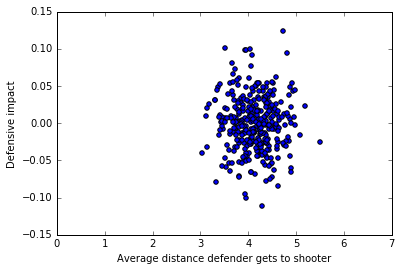

In [56]:
defender_df_100 = defender_df[defender_df["DFGA"]>100]
plt.scatter(defender_df_100["Average Defender Distance"],defender_df_100["diff"])
plt.ylabel("Defensive impact")
plt.xlabel("Average distance defender gets to shooter")
plt.xlim(0,7)
plt.show()

No obvious correlation between average distance a defender gets to the shooter and the defender's defensive impact.